In [2]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate

import matplotlib.pyplot as plt
import corner

from slsim.Plots.lens_plots import LensingPlots
import tqdm

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/home/paras/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paras/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


## Lensed quasar + host galaxy population

This notebook shows how to simulate lensed quasar population with/without host galaxies.

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=10, unit="deg2")
full_sky_area = Quantity(value=10, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 30, "z_min": 0.01, "z_max": 5}
kwargs_source_cut = {"z_min": 0.001, "z_max": 5.0}

In [4]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=None,
)

In [5]:
# Initiate deflector population class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/home/paras/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:56: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/home/paras/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:59: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [6]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)

# quasar sample without host galaxy
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30, host_galaxy=False)

# quasar sample with host galaxy
quasar_source_plus_galaxy = quasar_class.quasar_sample(
    m_min=15, m_max=30, host_galaxy=True
)

: 

In [ ]:
quasar_source

z,M_i,ps_mag_i
float64,float64,float64
2.6733058817920896,-23.56159296922221,22.294499960667764
2.213978540095596,-15.733631045329151,29.682027996800173
1.0334680339650517,-15.130953977703296,28.489207328329115
1.0333885180302627,-13.769868459612434,29.85016572674055
0.626425179895944,-12.983367004807313,29.463627448010413
3.348085476620237,-16.393919890186837,29.995060561569428
2.2212931759066854,-17.88485862753954,27.540867015964384
2.5808203706777983,-16.439674234346317,29.3745235340745
0.3756645038333393,-13.49125600480481,27.83379072226629


In [ ]:
quasar_source_plus_galaxy

z,M_i,ps_mag_i,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_y,vel_disp,black_hole_mass_exponent,eddington_ratio
,,,,,,kpc,,rad,,,,,,,,
float64,float64,float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.6733058817920896,-23.56159296922221,22.294499960667764,-21.797499180017944,0.094152177444753 .. 0.004754725951206937,0.46156721314797705,4.017927410808178,213282206219.4799,2.450736628347983e-06,25.708868597059872,25.6298699324136,25.456590961056992,25.454550182380483,25.345617247586144,194.3170380608341,8.436527975880733,0.27236682154636277
2.213978540095596,-15.733631045329151,29.682027996800173,-16.42161260681381,0.45959830038023175 .. 0.09837227575043828,0.49811874844194687,1.5788757033873808,314411754.97312194,9.269622116474257e-07,30.0165489970896,29.834805292158492,29.75878006571024,29.647084623642257,29.46494496580504,35.48779710703991,5.202196514603606,0.25002204291694924
1.0334680339650517,-15.130953977703296,28.489207328329115,-14.226168700982061,0.14088105046652608 .. 0.041614233559881295,0.18636023450164732,0.3737977578778341,90936439.83917938,2.2462126200076853e-07,30.893540199842917,30.411857794629057,29.843312544399858,29.227496383877046,29.00063764561797,31.561612271533754,4.979167522550812,0.23560094206570542
1.0333885180302627,-13.769868459612434,29.85016572674055,-15.092941509627632,0.21852689206823117 .. 0.07539133915656449,0.6905623276699369,1.365094939158761,155946980.84829605,8.201459916251904e-07,29.43491211834886,29.178777200809737,28.810530918917177,28.352227757699286,28.185677410563233,33.2686140727555,5.079362338691552,0.12188698310066366
0.626425179895944,-12.983367004807313,29.463627448010413,-12.918510028271108,0.1252010214614221 .. 0.0900562047756714,0.7878292860117121,0.46442594979512625,20335879.48152749,3.3012694564607553e-07,30.701769020228166,29.878872408807933,29.29270273498391,29.142859222056014,28.993000761874125,26.821317681224315,4.669593195134778,0.11159358318158384
3.348085476620237,-16.393919890186837,29.995060561569428,-18.929276934941054,0.38128399793094403 .. 0.16017728749835644,0.29401493519192573,1.5659095883450627,3230624043.271356,1.020863227999103e-06,29.48230014464584,29.00700317529084,28.778713957320583,28.568131940536418,28.43875699536772,42.86113442670068,5.561289150385833,0.1801151537183865
2.2212931759066854,-17.88485862753954,27.540867015964384,-17.422556350745204,0.08057966360519922 .. 0.030496302166138686,0.6748938622747339,0.8953804363856156,1394473771.0221777,5.259804625542343e-07,28.811173571384543,28.68583325637612,28.649099752673102,28.601063266784244,28.458577345106477,40.20212355494274,5.439460906440505,0.993042013363278
2.5808203706777983,-16.439674234346317,29.3745235340745,-16.657031428994614,0.5050333889685724 .. 0.18683740541886681,0.298556842012629,1.0053226194879972,341449048.89433706,6.080598255072484e-07,30.20712279760761,30.047092000767073,29.84076790063046,29.808583411834412,29.63487861831002,35.74888502890342,5.21614006785604,0.45465592650011677


In [ ]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}


kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    # "kwargs_variability_model": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
    "r_resolution": 500,
    "corona_height": 10,
}

In [ ]:
# Initiate source population classes.

# Point source quasar population without host galaxy
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    # catalog_type="skypy",
    point_source_type="quasar",
    point_source_kwargs=kwargs_quasar,
)

# Point source quasar population with host galaxy
source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    point_source_type="quasar",
    extended_source_type="single_sersic",
    point_source_kwargs=kwargs_quasar,
)

In [ ]:
# Initiate LensPop class to generate lensed quasar pop. We simulate lens pop in 500
# deg^2. If you want to simulate in larger sky, change sky area to your requirement.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

quasar_plus_galaxies_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Properties of the lensed quasar population

Text(0.5, 1.05, 'Quasar Source Population')

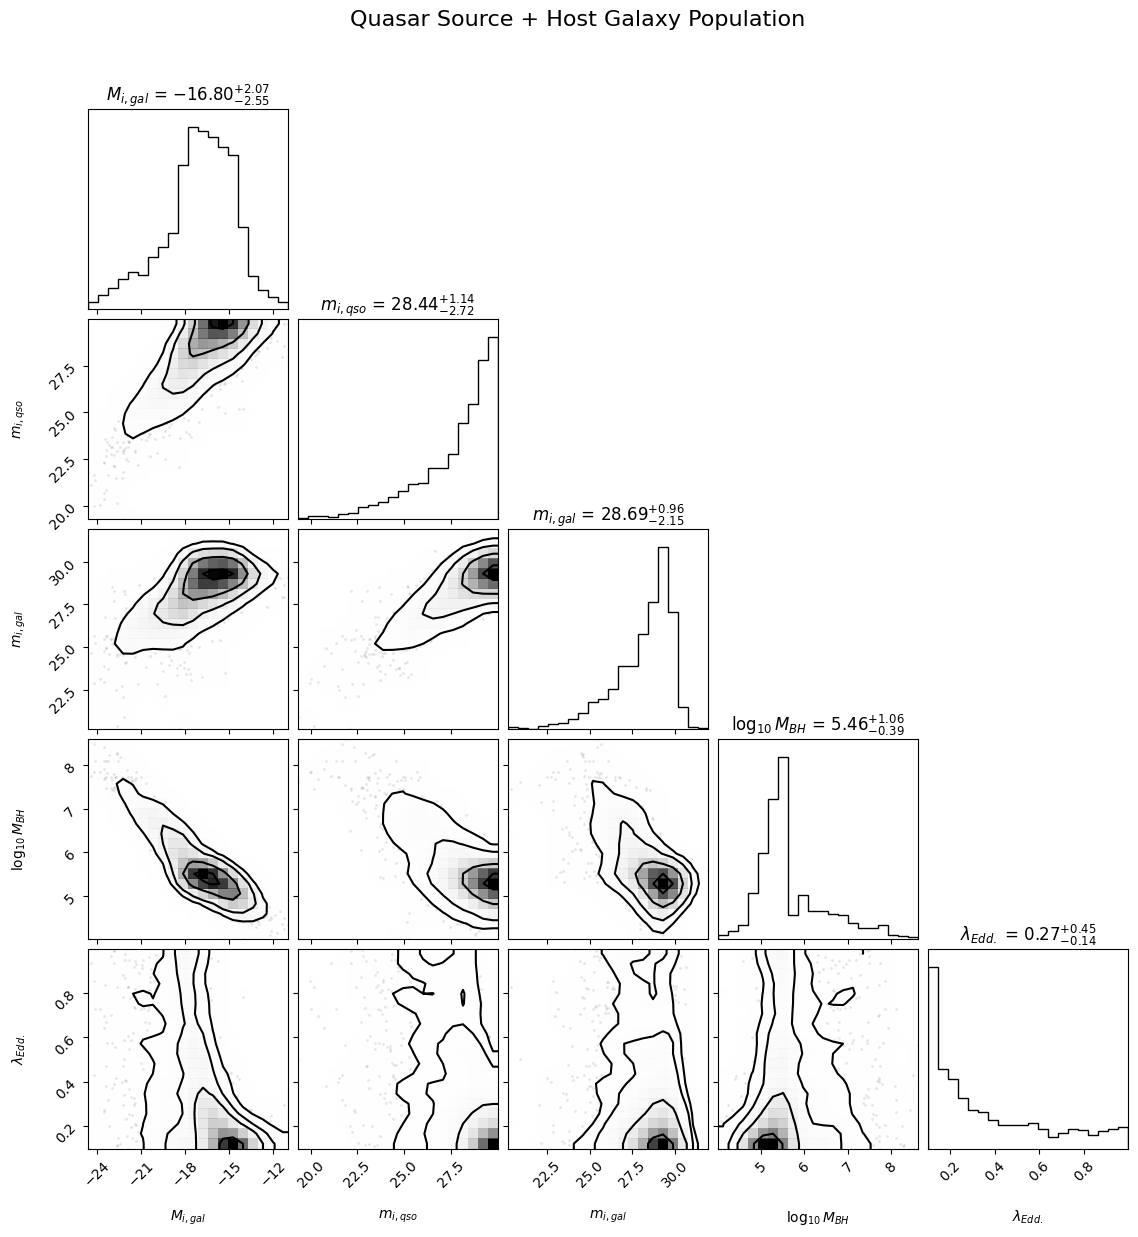

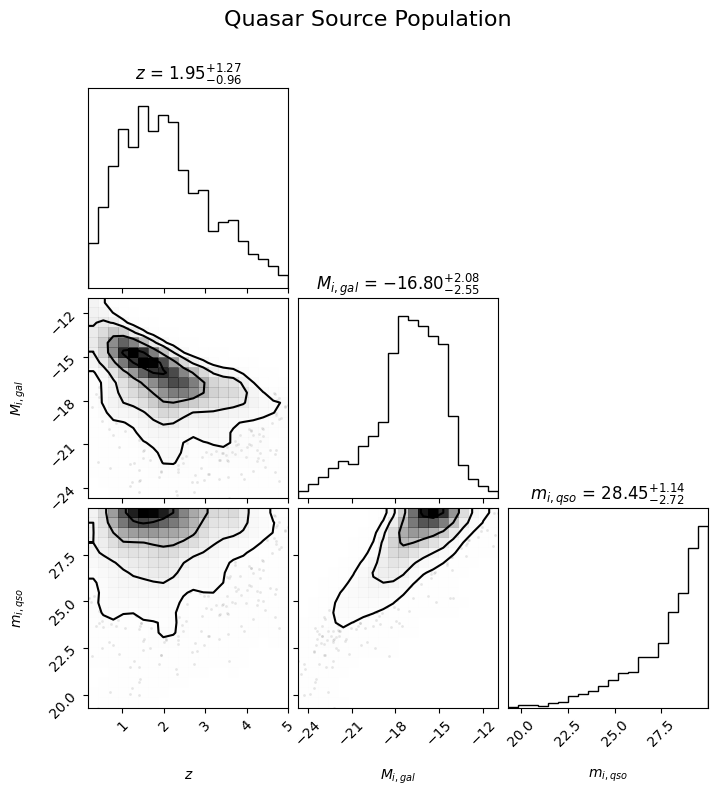

In [ ]:
# we make a corner plot for both the lens populations

keys = [
    # "z",
    "M_i",
    "ps_mag_i",
    "mag_i",
    "black_hole_mass_exponent",
    "eddington_ratio",
]

key_labels = {
    "z": r"$z$",
    "M_i": r"$M_{i, gal}$",
    "ps_mag_i": r"$m_{i, qso}$",
    "mag_i": r"$m_{i, gal}$",
    "black_hole_mass_exponent": r"$\log_{10} M_{BH}$",
    "eddington_ratio": r"$\lambda_{Edd.}$",
}

mask_finite = np.isfinite(quasar_source_plus_galaxy["black_hole_mass_exponent"])
data_qso_plus_gal = {key: quasar_source_plus_galaxy[key][mask_finite] for key in keys}

fig = corner.corner(
    data_qso_plus_gal,
    labels=[key_labels[key] for key in keys],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth=True,
)
fig.suptitle(
    "Quasar Source + Host Galaxy Population",
    fontsize=16,
    y=1.05,
)

data_qso_only = {key: quasar_source[key] for key in ["z", "M_i", "ps_mag_i"]}

fig = corner.corner(
    data_qso_only,
    labels=[key_labels[key] for key in data_qso_only.keys()],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth=True,
)
fig.suptitle(
    "Quasar Source Population",
    fontsize=16,
    y=1.05,
)

## Plot lenses

In [ ]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 4,
    "max_image_separation": 30,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(
    quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10
)

In [ ]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 2,
    # "max_image_separation": 30,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
    "second_brightest_image_cut": {"r": 24, "i": 24, "g": 24},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(
    quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10
)

# select lenses for plotting
selected_lenses_quasar = []
selected_lenses_quasar_plus_galaxies = []

for _ in tqdm.trange(16, desc="Selecting lenses at random"):
    selected_lenses_quasar.append(
        quasar_lens_pop.select_lens_at_random(
            **kwargs_lens_cut_plot,
        )
    )
    selected_lenses_quasar_plus_galaxies.append(
        quasar_plus_galaxies_lens_pop.select_lens_at_random(
            **kwargs_lens_cut_plot,
        )
    )

# get rgb images of the selected lenses
rgb_images_quasar = []
rgb_images_quasar_plus_galaxies = []

for i in tqdm.trange(len(selected_lenses_quasar), desc="Generating RGB images"):
    rgb_images_quasar.append(
        quasar_plot.rgb_image(
            selected_lenses_quasar[i],
            rgb_band_list=["i", "r", "g"],
        )
    )
    rgb_images_quasar_plus_galaxies.append(
        quasar_plus_galaxies_plot.rgb_image(
            selected_lenses_quasar_plus_galaxies[i],
            rgb_band_list=["i", "r", "g"],
        )
    )

print(f"Number of selected lenses [quasar]: {len(selected_lenses_quasar)}")
print(
    f"Number of selected lenses [quasar + host galaxy]: {len(selected_lenses_quasar_plus_galaxies)}"
)

Selecting lenses at random:   0%|          | 0/16 [00:00<?, ?it/s]/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paras/.venv/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Selecting lenses at random:   6%|▋         | 1/16 [01:34<23:34, 94.30s/it]


KeyboardInterrupt: 

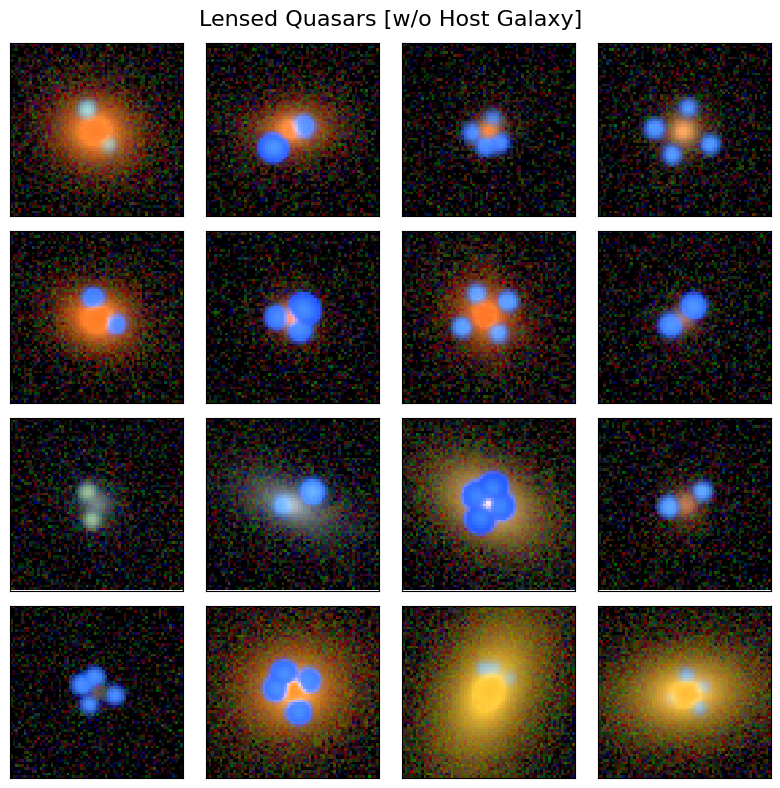

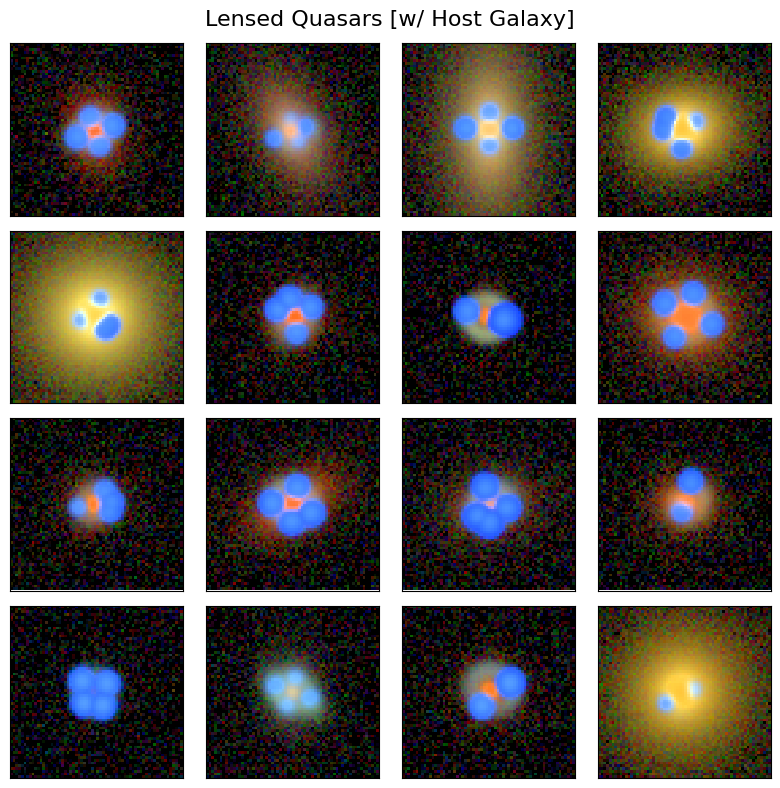

In [ ]:
# make montage of the rgb images for both the lens populations

# quasar lens montage
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(8, 8),
    subplot_kw={"xticks": [], "yticks": []},
)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            rgb_images_quasar[i * 4 + j],
            origin="lower",
            interpolation="nearest",
        )
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
# fig.subplots_adjust(top=0.9)
fig.tight_layout()

# quasar + host galaxy lens montage
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(8, 8),
    subplot_kw={"xticks": [], "yticks": []},
)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            rgb_images_quasar_plus_galaxies[i * 4 + j],
            origin="lower",
            interpolation="nearest",
        )
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
# fig.subplots_adjust(top=0.9)
fig.tight_layout()

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

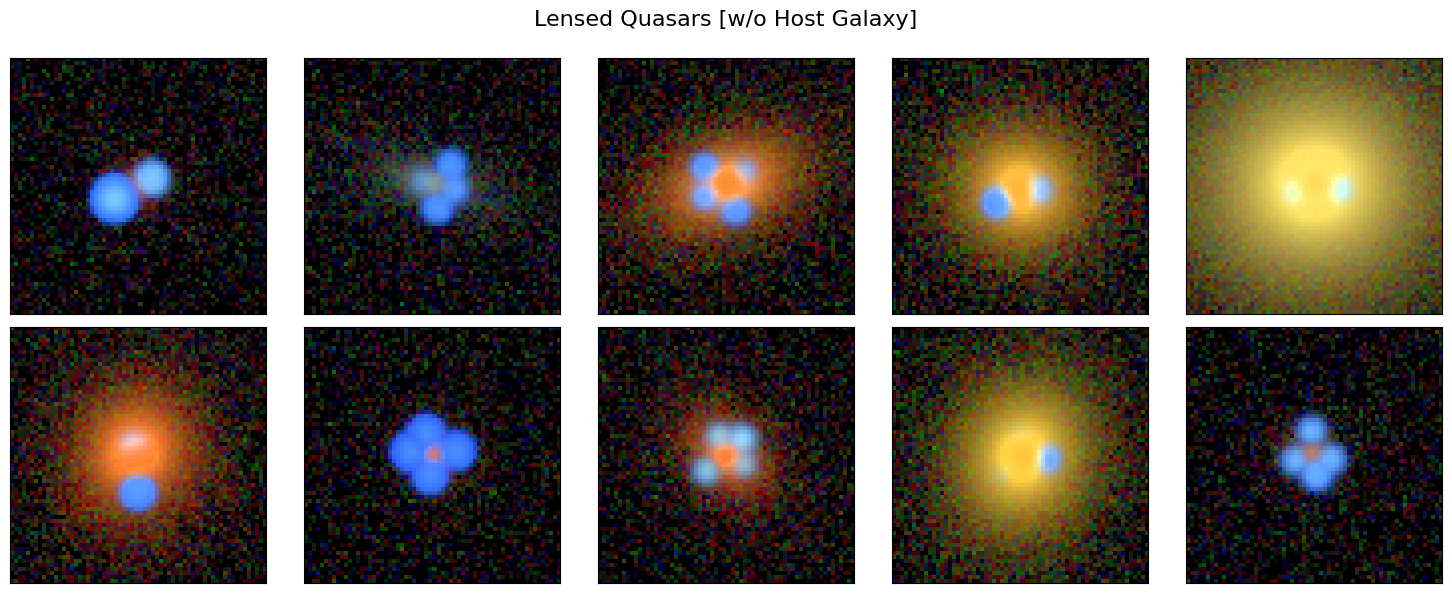

In [ ]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500
keyword corona_height is not defined, using default value of: 10
keyword r_resolution is n

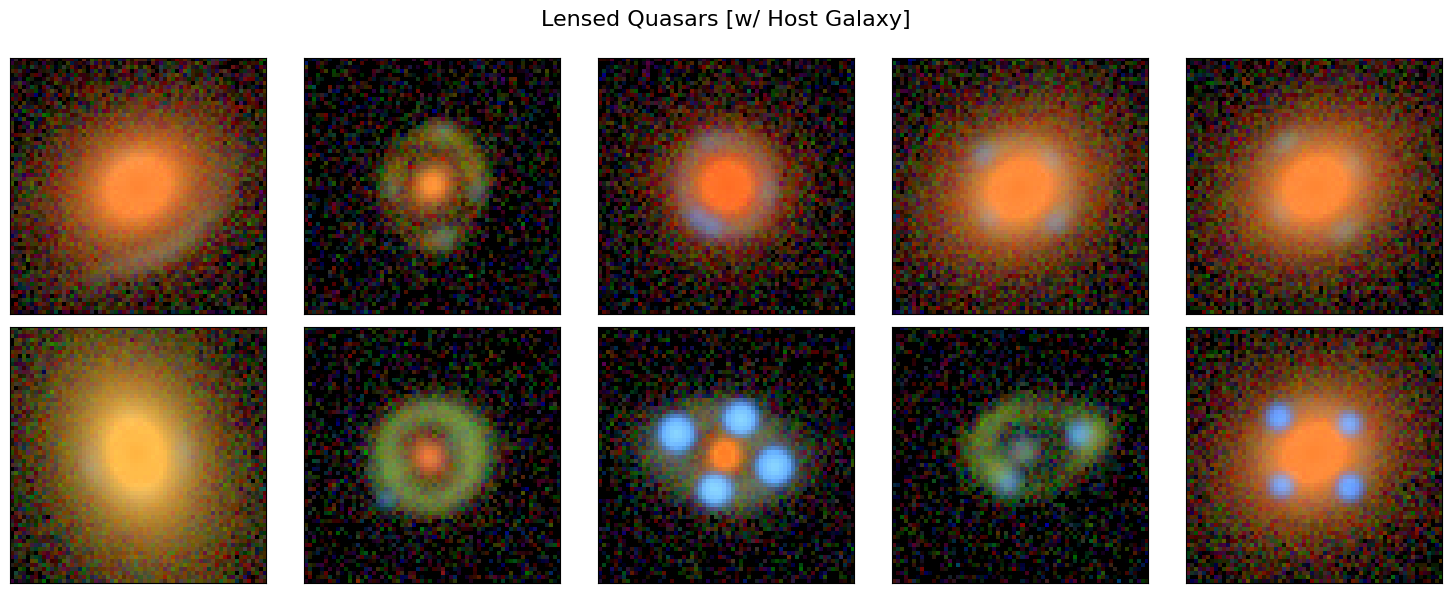

In [ ]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plus_galaxies_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()